# Model testing

Evaluate the saved XGBoost regressor on the held-out test dataset.

### Imports

In [1]:
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

### Variables

In [2]:
target_col = "movie_score"
drop_cols = ["movie_score", "averageRating", "numVotes", "Unnamed: 0", "_orig_order"]

### Retrieve data

In [3]:
testDatasetPath = os.path.join('..','..', 'data', 'test_dataset.csv')
final_model = joblib.load("random_forest_reg_movie_log_transformed.joblib")
df_test = pd.read_csv(testDatasetPath, sep=";")


### Prepare test data

In [4]:
# Load model and data
y_true = df_test[target_col].to_numpy()
y_true_original = np.expm1(y_true)
X_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns])



### Create prediction on test

In [5]:
# Predict
y_pred = final_model.predict(X_test)
y_pred_original = np.expm1(y_pred)

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


### Calculate MAE, RMSE and R^2

In [6]:
# Metrics (only if ground truth available)
if y_true is not None:
    mae = mean_absolute_error(y_true_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    r2 = r2_score(y_true, y_pred)
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
else:
    print("Ground-truth 'movie_score' not found in test set; only predictions are available.")


MAE:  2122.8651
RMSE: 17464.0752
R2:   0.4924


In [7]:
# --- Bin-based evaluation ---
bin_edges = [0, 10, 50, 100, 500, 1000, 5000, 10000, 20000, 40000, np.inf]
bin_labels = ["0-10", "10-50", "50-100", "100-500", "500-1000", "1000-5000", "5000-10000", "10000-20000", "20000-40000", "40000+"]

eval_df = pd.DataFrame({
    "y_true": y_true_original,
    "y_pred": y_pred_original
})

# Put each row into a bin based on TRUE score (recommended)
eval_df["score_bin"] = pd.cut(
    eval_df["y_true"],
    bins=bin_edges,
    labels=bin_labels,
    right=False,          # [low, high)
    include_lowest=True
)

def metrics_for_slice(y_t, y_p):
    return {
        "n": len(y_t),
        "mae": mean_absolute_error(y_t, y_p),
        "rmse": np.sqrt(mean_squared_error(y_t, y_p)),
        "mean_true": float(np.mean(y_t)),
        "mean_pred": float(np.mean(y_p)),
        "median_abs_err": float(np.median(np.abs(y_p - y_t))),
    }

bin_results = (
    eval_df.dropna(subset=["score_bin"])
           .groupby("score_bin", observed=True)
           .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))
           .reset_index()
)

print("\nPer-bin performance (binned by TRUE movie_score):")
print(bin_results.to_string(index=False))



Per-bin performance (binned by TRUE movie_score):
  score_bin       n          mae          rmse     mean_true    mean_pred  median_abs_err
       0-10  5545.0    69.422393    731.402491      7.424166    76.846559       30.649112
      10-50 21845.0   102.458224   1175.347215     23.738567   124.816348       29.409991
     50-100  8247.0   142.985126    744.464543     70.671759   188.806720       38.672312
    100-500 14836.0   320.993644   2771.698153    233.517660   386.151583      124.327671
   500-1000  4343.0   743.507503   2512.394000    706.105227   734.991020      475.543918
  1000-5000  6395.0  2160.752480   5688.950914   2189.017201  1587.451644     1386.789245
 5000-10000  1255.0  6213.697457   9626.343867   7028.812749  4140.608710     5396.204165
10000-20000   852.0 12631.532897  18646.373491  14081.359155  8104.613739    10847.969651
20000-40000   544.0 23460.844212  29873.056480  28386.556985 14219.292194    22401.089857
     40000+   838.0 95960.313695 148376.431629 13

/var/folders/74/dcwqhys10x5cqq_c4j3fdmnm0000gn/T/ipykernel_18413/990017722.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))


In [8]:
bin_results.to_csv("bin_results.csv", index=False)

In [9]:
eval_df["pred_bin"] = pd.cut(
    eval_df["y_pred"],
    bins=bin_edges,
    labels=bin_labels,
    right=False,
    include_lowest=True
)

pred_bin_results = (
    eval_df.dropna(subset=["pred_bin"])
           .groupby("pred_bin", observed=True)
           .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))
           .reset_index()
)

print("\nPer-bin performance (binned by PREDICTED movie_score):")
print(pred_bin_results.to_string(index=False))


/var/folders/74/dcwqhys10x5cqq_c4j3fdmnm0000gn/T/ipykernel_18413/1288564663.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(metrics_for_slice(g["y_true"].values, g["y_pred"].values)))



Per-bin performance (binned by PREDICTED movie_score):
   pred_bin       n          mae          rmse     mean_true     mean_pred  median_abs_err
      10-50 20089.0   107.568995    816.610144    118.206481     34.197588       21.268756
     50-100 13660.0   221.977719   1287.758064    240.145827     70.925629       49.746209
    100-500 20333.0   695.121804   4864.645813    760.170757    224.405776      147.639542
   500-1000  4295.0  2063.945837   8617.608101   2284.636321    698.943614      529.208253
  1000-5000  4304.0  5871.877516  18091.891135   6569.409154   2130.641747     1495.085215
 5000-10000   755.0 16235.448402  41364.995588  18874.958940   6996.669082     5577.577630
10000-20000   480.0 27730.429282  56269.243017  32123.152083  14292.348997    11707.369341
20000-40000   319.0 42192.943319  91867.964176  52544.200627  27716.994138    20591.834005
     40000+   465.0 96467.017731 160538.327649 145221.374194 112287.380996    55522.407955


In [10]:
pred_bin_results.to_csv('performance_binned_by_predicted.csv', index=False)

### Create a preview dataframe

In [11]:
# Preview predictions
preview = pd.DataFrame({"predicted_movie_score": y_pred, "residual": y_pred - y_true})
if y_true is not None:
    preview.insert(0, "actual_movie_score", y_true)


### Create a dataframe of feature importance

In [12]:
importances = final_model.feature_importances_
feature_names = X_test.columns

# Create sorted DataFrame
importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)
print(importance_df.head(10))

                       feature  importance
4       prior1_rating_director    0.118331
8   actor1_prior2_rating_actor    0.061118
5       prior2_rating_director    0.059245
9   actor1_prior3_rating_actor    0.057822
7   actor1_prior1_rating_actor    0.052243
6       prior3_rating_director    0.041438
11  actor2_prior1_rating_actor    0.037024
12  actor2_prior2_rating_actor    0.035494
13  actor2_prior3_rating_actor    0.028491
15  actor3_prior1_rating_actor    0.027585


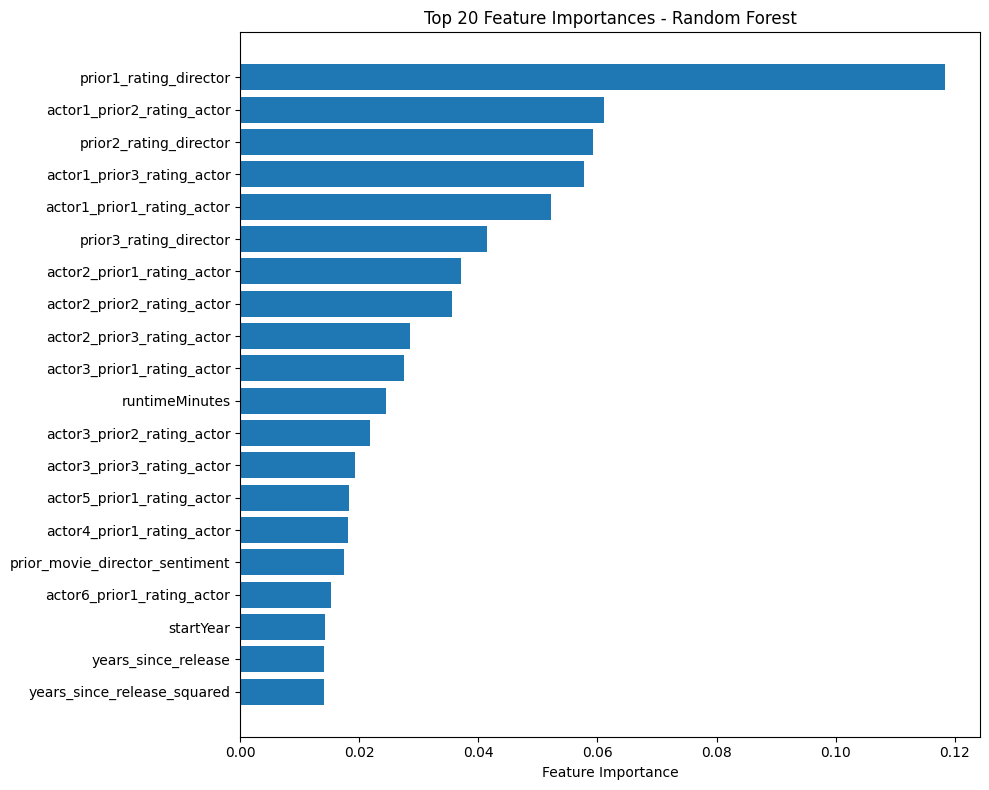

In [13]:
# Visualize top 20 feature importances
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Graph over residuals

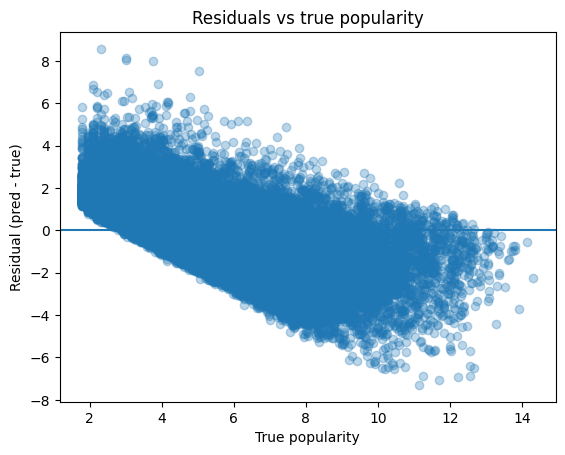

In [14]:
residuals = y_pred - y_true

plt.figure()
plt.scatter(y_true, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("True popularity")
plt.ylabel("Residual (pred - true)")
plt.title("Residuals vs true popularity")
plt.show()


### Bias plot

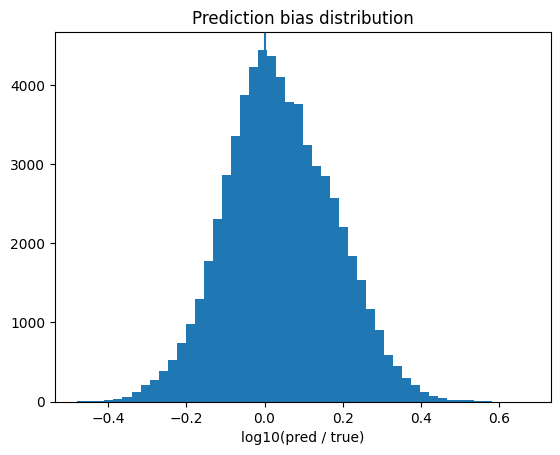

In [15]:
ratio = y_pred / (y_true + 1e-9)
plt.figure()
plt.hist(np.log10(ratio), bins=50)
plt.axvline(0)  # log10(1)
plt.xlabel("log10(pred / true)")
plt.title("Prediction bias distribution")
plt.show()

